<a href="https://colab.research.google.com/github/marloncalvo/cap4630-spr2020/blob/master/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

# Problem 1

## Data Generation Functions

To define how `get_random_data(...)` generates training data  

$Let,$

$$
 G_{ab} \text{ be a gaussian distribution, where } \mu=a \text{ and } \sigma=b.  \tag{1}
$$

$$
 f(x,c,n)=wx + b + (-1)^c * n, \text{ where } w \in \mathbb R, b\in \mathbb R, x \in [0,1], c \in \{0,1\}, \text{ and } n \in G. \tag 2
$$

$$
 g(x)=wx + b \tag 3
$$

It is evident that $g$ forms the decision boundary line for $f$. The bias for $f$ increases or decreases $g$, depending on $c$,  by some normal amount $n$.
Thus, in the `get_random_data(w, b, mu, sigma, m)` function, we are generating data for $f$, with the decision boundary $g$, where the data is uniformly separated under and over $f$.



In [0]:
import random
import numpy as np
import matplotlib.pyplot as plt

def get_random_data(w, b, mu, sigma, m):
  random.seed(1)
  data = []
  labels = []
  samples = np.random.default_rng().normal(loc=mu, scale=sigma, size=(m,))
  for sample in samples:
    c = random.choice((0, 1))
    x = random.uniform(0, 1)
    y = w * x + b + (-1) ** c * sample
    data.append((x, y))
    labels.append(c)

  data = np.array(data, dtype=[('x', '<f4'), ('y', '<f4')])
  labels = np.array(labels).reshape((len(labels), 1))

  return data, labels

def display_random_data(data, labels, plots):

  def gen_data(data, labels):
    out = {}
    for i, label in enumerate(labels.flatten()):
      arr = out.get(label, [[], []])
      arr[0].append(data[i][0])
      arr[1].append(data[i][1])
      out[label] = arr

    return out


  split_data = gen_data(data, labels)

  fig, ax = plt.subplots()
  ax.plot(*split_data[0], 'ro', *split_data[1], 'bo')
  for plot in plots:
    (w, b, label) = plot
    data = [[0, 1],[b, w+b]]
    ax.plot(*data, label=label)

  ax.legend(loc='upper right')
  plt.suptitle('Decision Boundary Plot(s)')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()

def shuffle_data(data, labels):
  indices = np.arange(data.shape[0])
  np.random.shuffle(indices)

## Data Generation

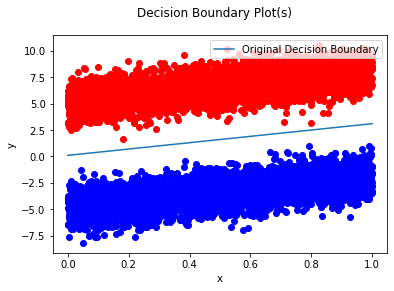

In [2]:
import math
from numpy.lib.recfunctions import structured_to_unstructured

#w = .001; b = .1; size = 100000
w = 3; b = .1; size = 10000
data, labels = get_random_data(w, b, 5, 1, size)
shuffle_data(data, labels)

display_random_data(data, labels, [(w, b, "Original Decision Boundary")])

# To avoid utilizing some feature pipeline, let's just do this
# for now.
unstruct_data = structured_to_unstructured(data)

test_size       = math.floor(size * 0.3)
train_size      = size - test_size

test_data,  test_labels  = unstruct_data[:test_size], labels[:test_size]
train_data, train_labels = unstruct_data[test_size:], labels[test_size:]

# Problem 2

## Model Setup

Earlier, we saw that equation (3) describes the boundary line of equation (2).
By performing linear regression on the data produced by `get_random_data(...)`, we are building a model who's decision boundary approximates (3).

We can determine the model's decision boundary by using it's weights.  
  

$Let,$

$$ y, \text{ an example of our dataset } \tag 4 $$

$$ z(x) = w_1x_1 + w_2x_2 + b \tag 5$$

$$ a(x) = \sigma(x) \tag 6$$

$$ d(x) = \begin{cases}
          0, & x < 0.5 \\
          1, & x >= 0.5
          \end{cases}
          \tag 7
$$

$\text{Then,} $

$$ \text{y's class = } d(a(z(y))) \tag 8$$ 

Equation (8) describes what occurs under the hood by Keras when peforming logistic regression  on a single neuron output/input layer with sigmoid activation.  
  
  
As seen by the cases for (7), if the value of $x=0.5$, it is in some sense "guessing" (50% chance for either class). The "farther" values from $1/2$ indicate a stronger confidence that $x$ belongs in it's corresponding class. Thus, our model will tend to fit (5) such that if $y$ is in class $0$, $x$ will be closer to $0$, and closer to $1$ if $y$ is in class $1$.  
  

We can use this information to determine (5), for the trained model, from its final weights after training. To do so, we need obtain the models $w_1,w_2,b$ parameters and perform the following equation. In essence, we want to obtain when $d: x=1/2$, and since $\sigma(0)=1/2$, we must find when $z(x)=0$.
  
$Let, $

$$ \text{ W = Trained Model Weights} $$

$$ w_1 \in W, w2 \in W, b \in W $$

$Then, $

$$ \text{Since } \sigma(0) = 1/2,$$

$$ 0 = w_1x_1 + w_2x_2 + b $$ 

$$ w = x_1, y = x_2 $$

$$ x_2 = -\frac{w_1x_1 + b}{w_2} $$

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

def get_decision_boundary_f(w_1, w_2, bias):
  f = lambda x: -((w_1*x)+bias)/(w_2)
  return f

# Took inspiration from: https://stackoverflow.com/questions/53741412/plot-decision-boundary-somehow-not-giving-any-output
def plot_decision_boundary(train_data, train_labels, model, steps=100, cmap='Paired'):
    """
    Function to plot the decision boundary and data points of a model.
    Data points are colored based on their actual label.
    """
    cmap = plt.get_cmap(cmap)

    train_x = train_data[:,0]
    train_y = train_data[:,1]

    _x = np.linspace(0, 1, steps)
    _y = np.linspace(min(train_y), max(train_y), steps)
    x, y = np.meshgrid(_x, _y)

    # Make predictions across region of interest
    z = model.predict(np.c_[x.ravel(), y.ravel()]).reshape(x.shape)

    fig, ax = plt.subplots()
    ax.contourf(x, y, z, cmap=cmap, alpha=0.8)

    # Get predicted labels on training data and plot
    ax.scatter(train_x, train_y, c=train_labels, cmap=cmap, lw=0)

    plt.suptitle('Decision Boundary Heatmap of Model')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

def get_model():
  optimizer = SGD(lr=0.05)
  model = Sequential()
  model.add(Dense(1, activation='sigmoid', input_shape=(2,)))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])
  
  return model

## Model Training

In [0]:
model = get_model()
history = model.fit(train_data, train_labels, epochs=10, validation_split=0.15)

w_0 = model.layers[0].get_weights()[0][0][0]
w_1 = model.layers[0].get_weights()[0][1][0]
bias = model.layers[0].get_weights()[1][0]

print(model.layers[0].get_weights())

f = get_decision_boundary_f(w_0, w_1, bias)
bias = f(0)
slope = f(1) - bias

Epoch 1/10
186/186 [==============================] - 0s 2ms/step - loss: 0.6128 - binary_accuracy: 0.7499 - val_loss: 0.4164 - val_binary_accuracy: 1.0000
Epoch 2/10
186/186 [==============================] - 0s 1ms/step - loss: 0.2967 - binary_accuracy: 1.0000 - val_loss: 0.2004 - val_binary_accuracy: 1.0000
Epoch 3/10
186/186 [==============================] - 0s 1ms/step - loss: 0.1421 - binary_accuracy: 1.0000 - val_loss: 0.0958 - val_binary_accuracy: 1.0000
Epoch 4/10
186/186 [==============================] - 0s 1ms/step - loss: 0.0684 - binary_accuracy: 1.0000 - val_loss: 0.0465 - val_binary_accuracy: 1.0000
Epoch 5/10
186/186 [==============================] - 0s 1ms/step - loss: 0.0337 - binary_accuracy: 1.0000 - val_loss: 0.0233 - val_binary_accuracy: 1.0000
Epoch 6/10
186/186 [==============================] - 0s 2ms/step - loss: 0.0172 - binary_accuracy: 1.0000 - val_loss: 0.0122 - val_binary_accuracy: 1.0000
Epoch 7/10
186/186 [==============================] - 0s 1ms/ste

## Model Evaluation

94/94 [==============================] - 0s 1ms/step - loss: 0.0017 - binary_accuracy: 1.0000


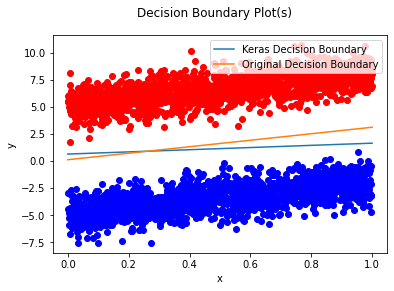

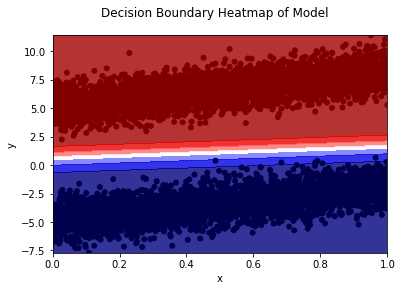

In [0]:
results = model.evaluate(test_data, test_labels)
display_random_data(test_data, test_labels, [(slope, bias, "Keras Decision Boundary"), (w, b, "Original Decision Boundary")])
plot_decision_boundary(train_data, train_labels, model, cmap='seismic_r')

# Problem 3

We utilize a similar approach as to modeling with Keras, except we are implementing all the required functions.

## Model Training Functions

Similar to the Keras implementation, we are using the sigmoid activation function on the outputs of our predictions, to map our values to a domain defining the probability of some value X, belonging to group.
  
The workflow is as follows:  
$Let,$  
$$x = (x_0, x_1, x_2), \text{where } x_i \text{ regards to each component of } x$$
$$x_0 = 1, \text{ as a constant bias}$$
$Then,$
$$z(x) = \sigma(\sum_{i=0}^{2}x_i*w_i)$$

Which, can then be utilized to calculate the gradient, against sigmoid/bcle as such:  
$Let,$
$$lr = (0, 1]$$
$$gradient(x) \rightarrow [g_0, g_1, g_2]$$
$$gradient(x) = x(z(x)−y)$$  
$Then,$
$$W(x) = W - gradient(x) * lr$$
  
To compute the loss, we simply call binary cross entropy with the expected and predicted results.  
Reference: https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a  

The code below implements such, except in a vectorized manner.

In [0]:
def sigmoid(x):
   return 1. / (1. + np.exp(-x))

def predict(W, X):
  Z = X @ W
  return sigmoid(Z)

def prediction_accuracy(A, Y):
  decisions = decision_boundary(A)
  correct_decisions = len(np.where(decisions == Y)[0])

  acc = correct_decisions / len(Y)

  return acc

@np.vectorize
def decision_boundary(A):
  return 1 if A >= .5 else 0

def binary_crossentropy(A, Y):
  cost = np.negative(Y) * np.log(A) - (1 - Y) * np.log(1 - A)
  cost = cost.sum() / len(Y)

  return cost

def split_training_data(X, Y, validation_split):
  n = len(X) - math.floor(len(X) * validation_split)

  X_val, Y_val = X[n:], Y[n:]
  X, Y = X[:n], Y[:n]

  return (X, Y), (X_val, Y_val)

def print_info(loss, acc, val_loss, val_acc, epoch):
  format = f'Epoch {epoch}: loss={loss:.4f} acc={acc:.4f}'
  if not val_loss is None and not val_acc is None:
    format = format + f' val_loss={val_loss:.4f} val_acc={val_acc:.4f}'

  print(format)

class History():
  def __init__(self):
    self.train_loss = []
    self.train_acc  = []
    self.val_loss   = []
    self.val_acc    = []
    self.weights    = []

In [0]:
class Model:
  def __init__(self):
    self.history = None

  def train(self, X, Y, lr=0.1, epochs=10, validation_split=0):

    X = np.hstack((np.ones((X.shape[0], 1)), X))
    W = np.ones((X.shape[1], 1))

    (X, Y), (X_val, Y_val) = split_training_data(X, Y, validation_split)

    val_size = len(Y_val)
    N = len(Y)
    
    history = History()
    self.history = history

    for epoch in range(epochs):

      A = predict(W, X)

      loss = binary_crossentropy(A, Y)
      acc  = prediction_accuracy(A, Y)

      # Derivative of bcel w. sigmoid activation: (a - y) * xi
      # took some inspiration from: https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html
      gradient = (X.T @ (A - Y)) / N
      W -= gradient * lr

      val_loss = val_acc = None

      if val_size > 0:
        A_val = predict(W, X_val)
        val_loss = binary_crossentropy(A_val, Y_val)
        val_acc  = prediction_accuracy(A_val, Y_val)

      history.train_loss.append(loss)
      history.train_acc.append(acc)
      history.val_loss.append(val_loss)
      history.val_acc.append(val_acc)

      print_info(loss, acc, val_loss, val_acc, epoch)

    history.weights = W

    return history

  def predict(self, X):
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    return decision_boundary(predict(self.history.weights, X))

## Model Training

In [11]:
model = Model()
history = model.train(train_data, train_labels, lr=0.1, epochs=10, validation_split=0.3)

bias = history.weights[0][0]
w_0 = history.weights[1][0]
w_1 = history.weights[2][0]

f = get_decision_boundary_f(w_0, w_1, bias)
bias = f(0)
slope = f(1) - bias

print(f'y={slope}*x + {bias}')

Epoch 0: loss=5.2020 acc=0.0494 val_loss=2.9490 val_acc=0.1900
Epoch 1: loss=2.9626 acc=0.1837 val_loss=1.2096 val_acc=0.4900
Epoch 2: loss=1.2109 acc=0.4906 val_loss=0.3369 val_acc=0.9262
Epoch 3: loss=0.3344 acc=0.9380 val_loss=0.1583 val_acc=0.9995
Epoch 4: loss=0.1561 acc=0.9994 val_loss=0.1084 val_acc=0.9995
Epoch 5: loss=0.1065 acc=0.9998 val_loss=0.0843 val_acc=1.0000
Epoch 6: loss=0.0827 acc=0.9998 val_loss=0.0699 val_acc=1.0000
Epoch 7: loss=0.0684 acc=0.9998 val_loss=0.0602 val_acc=1.0000
Epoch 8: loss=0.0589 acc=0.9998 val_loss=0.0532 val_acc=1.0000
Epoch 9: loss=0.0520 acc=0.9998 val_loss=0.0479 val_acc=1.0000
y=1.4151271953858833*x + 1.3412500551974131


## Model Evaluation

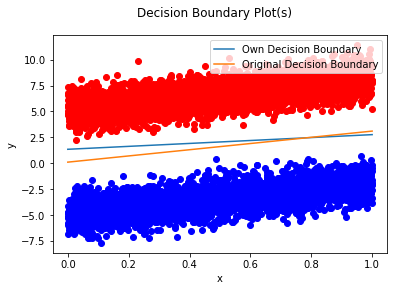

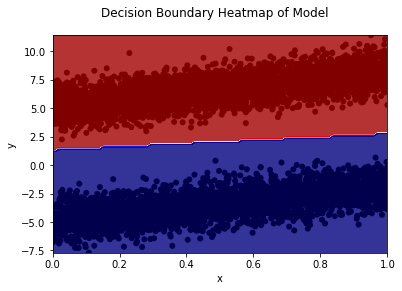

In [0]:
display_random_data(train_data, train_labels, [(slope, bias, "Own Decision Boundary"), (w, b, "Original Decision Boundary")])
plot_decision_boundary(train_data, train_labels, model, steps=100, cmap='seismic_r')

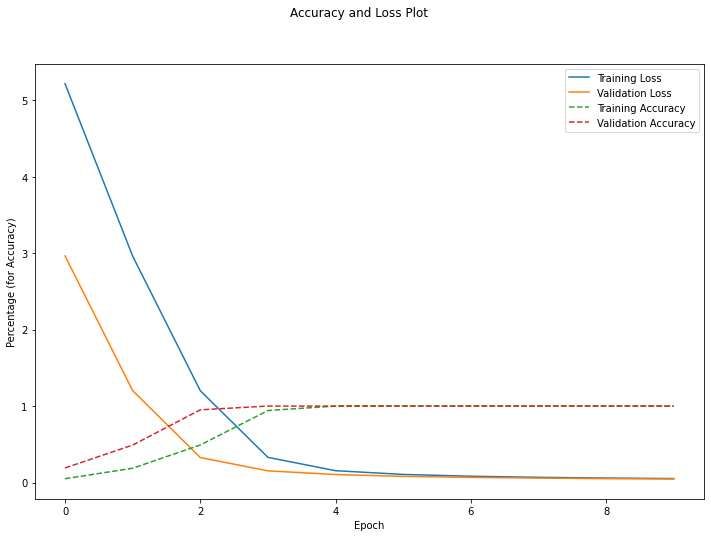

In [0]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Accuracy and Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Percentage (for Accuracy)')
plt.plot(history.train_loss, label='Training Loss')
plt.plot(history.val_loss, label='Validation Loss')
plt.plot(history.train_acc, '--', label='Training Accuracy')
plt.plot(history.val_acc, '--', label='Validation Accuracy')
plt.legend()